#### Start by Importing Libraries

In [152]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from queue import Queue
from moviepy.editor import VideoFileClip

In [153]:
%matplotlib inline

In [154]:
# skip calibration

#### Read our Test images

In [155]:
image_straight_lines1= cv2.imread("test_images/straight_lines1.jpg")
image_test1= cv2.imread("test_images/test1.jpg")
image_test2= cv2.imread("test_images/test2.jpg")
image_test3= cv2.imread("test_images/test3.jpg")
image_test4= cv2.imread("test_images/test4.jpg")
image_test5= cv2.imread("test_images/test5.jpg")
image_test6= cv2.imread("test_images/test6.jpg")
test_images=[image_straight_lines1,image_test1,image_test2,image_test3,image_test4,image_test5,image_test6,]

#### Perspective Transform

We need to select some coordinates to decide the trapezoid to use so we experiment with several points until we reach the ones below!

In [156]:
height, width= image_test1.shape[0], image_test1.shape[1]

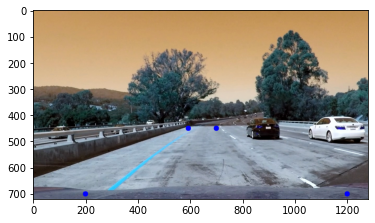

In [157]:
image_test1_cpy= cv2.imread("test_images/test1.jpg")
cv2.circle(image_test1_cpy,(593,450),10,(0,0,255),-1) #TL
cv2.circle(image_test1_cpy,(700,450),10,(0,0,255),-1) #TR
cv2.circle(image_test1_cpy,(1200,700),10,(0,0,255),-1) #BR
cv2.circle(image_test1_cpy,(200,700),10,(0,0,255),-1) #BL
plt.imshow(image_test1_cpy)

In [158]:
# we'll use these 4 points to create a matrix for perspective transformation
pts1=np.float32([(593,450),(700,450),(1200,700),(200,700)])
# size/coord of new image
pts2=np.float32([(200,0),(width-200,0),(width-200,height),(200,height)])

In [159]:
# Now we have to point sets for perspective transformation
def perspective_Trans(img):
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    inv= cv2.getPerspectiveTransform(pts2, pts1) #inverse matrix 
    result = cv2.warpPerspective(img,matrix,(width,height)) #warp the img
    return result,inv

In [160]:
# to reverse the image back 
def reverse_Perspective(img,M):
    unwarped_img= cv2.warpPerspective(img, M, (width,height), flags=cv2.INTER_LINEAR)
    return unwarped_img

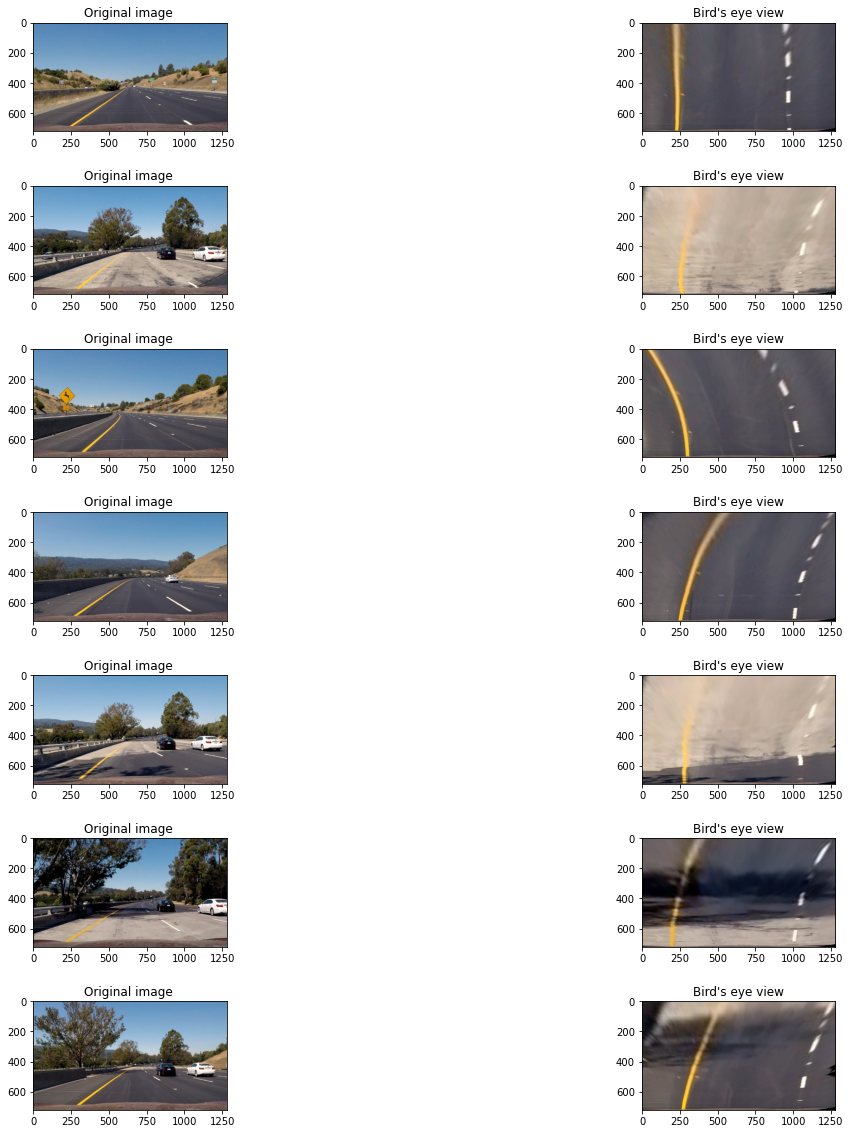

In [161]:
# View warped test images 
f,axes= plt.subplots(len(test_images),2, figsize=(20,20))
f.subplots_adjust(hspace=0.5)
row=0
images=[]

for img in test_images:
    image= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warped,inv= perspective_Trans(image)
    images.append(warped)
    axes[row,0].imshow(image)
    axes[row,0].set_title('Original image ')
    axes[row,1].imshow(warped)
    axes[row,1].set_title("Bird's eye view")
    row+=1    

### Our desired colors are lane colors aka (either yellow or white)

#### HSL,YCrCb color space (experiment with different  channels) 

HSL (Hue, Saturation, Lightness) color space concept is based on human vision color perception.That is why it's easier to distinguish desired colors (yellow and white) than in RGB/BGR space even if there are shadows on the image. Avoid using saturation because it's noisy 

In [162]:
def create_mask(img):
    converted = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # white ranges
    # cv2.inRange to filter the white color and the yellow color seperately.
    # white color = high Light value. No need to filter Hue, Saturation values.
    lo = np.uint8([  0, 200,   0])
    hi = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lo, hi)
    # Yellow ranges
    # Hue around 40 = yellow color.
    # relatively high Saturation
    lo = np.uint8([ 10,   0, 100])
    hi = np.uint8([ 50, 255, 255])
    yellow_mask = cv2.inRange(converted, lo,hi)
    # cv2.bitwise_or to combine these two binary masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    # cv2.bitwise_and to apply the combined mask onto the original image
    combined_mask=cv2.bitwise_and(img, img, mask = mask)
    return combined_mask


In [163]:
def binary_Thresholding (img,threshold):
    img = img*(255/np.max(img))
    binary_img = np.zeros_like(img)
    binary_img[(img > threshold[0]) & (img <= threshold[1])] = 1
    return binary_img

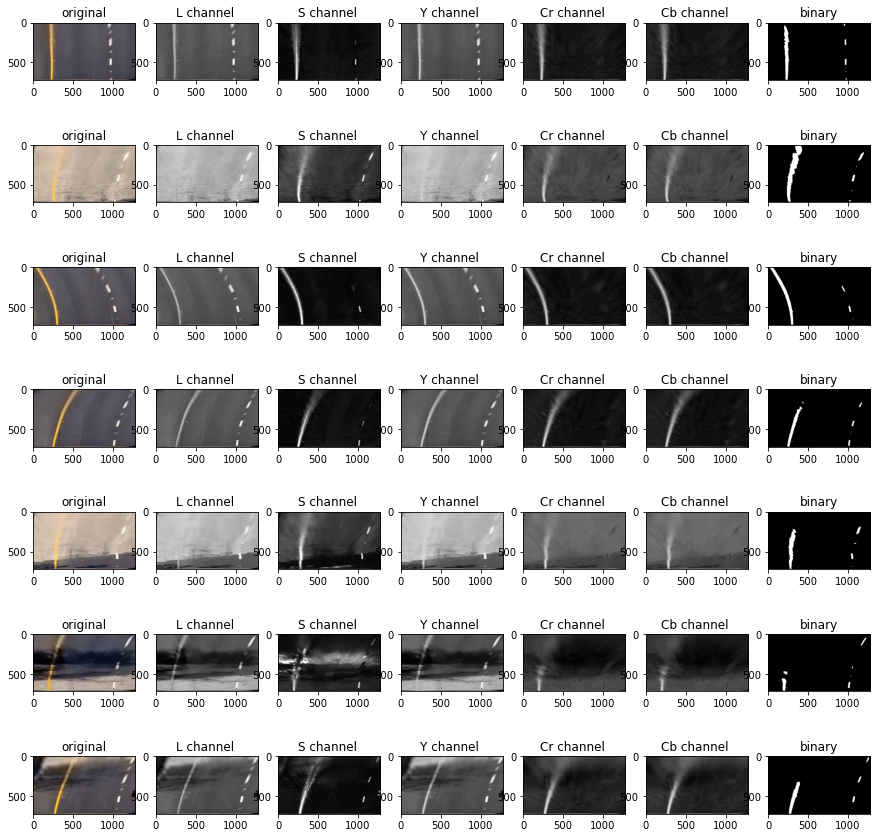

In [164]:
# view channels
f,axes= plt.subplots(len(images),7, figsize=(15,15))
f.subplots_adjust(hspace =0.5)
row=0
binary_images=[]
for image in images:
    img_hls= cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    img_crcb=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    h, l, s = cv2.split(img_hls)
    y,cr,cb=cv2.split(img_crcb)
    axes[row,0].imshow(image)
    axes[row,0].set_title('original')
    axes[row,1].imshow(l,cmap='gray')
    axes[row,1].set_title('L channel ')
    axes[row,2].imshow(s,cmap='gray')
    axes[row,2].set_title('S channel ')
    axes[row,3].imshow(y,cmap='gray')
    axes[row,3].set_title('Y channel ')
    axes[row,4].imshow(cr,cmap='gray')
    axes[row,4].set_title('Cr channel ')
    axes[row,5].imshow(cr,cmap='gray')
    axes[row,5].set_title('Cb channel ')
    bin_l=binary_Thresholding(l,(215,255))
    bin_y=binary_Thresholding(y,(215,255))
    bin_cr=binary_Thresholding (cr,(215,255))
    bin_cb=binary_Thresholding (cb,(0,40))
    combined_channels= cv2.bitwise_or(bin_l, bin_cr)
    combined_channels= cv2.bitwise_or(combined_channels, bin_y)
    combined_channels= cv2.bitwise_or(combined_channels, bin_cb)
    binary_images.append(combined_channels)
    axes[row,6].imshow(combined_channels,cmap='gray')
    axes[row,6].set_title('binary')
    row+=1

### Histogram to view pixel position

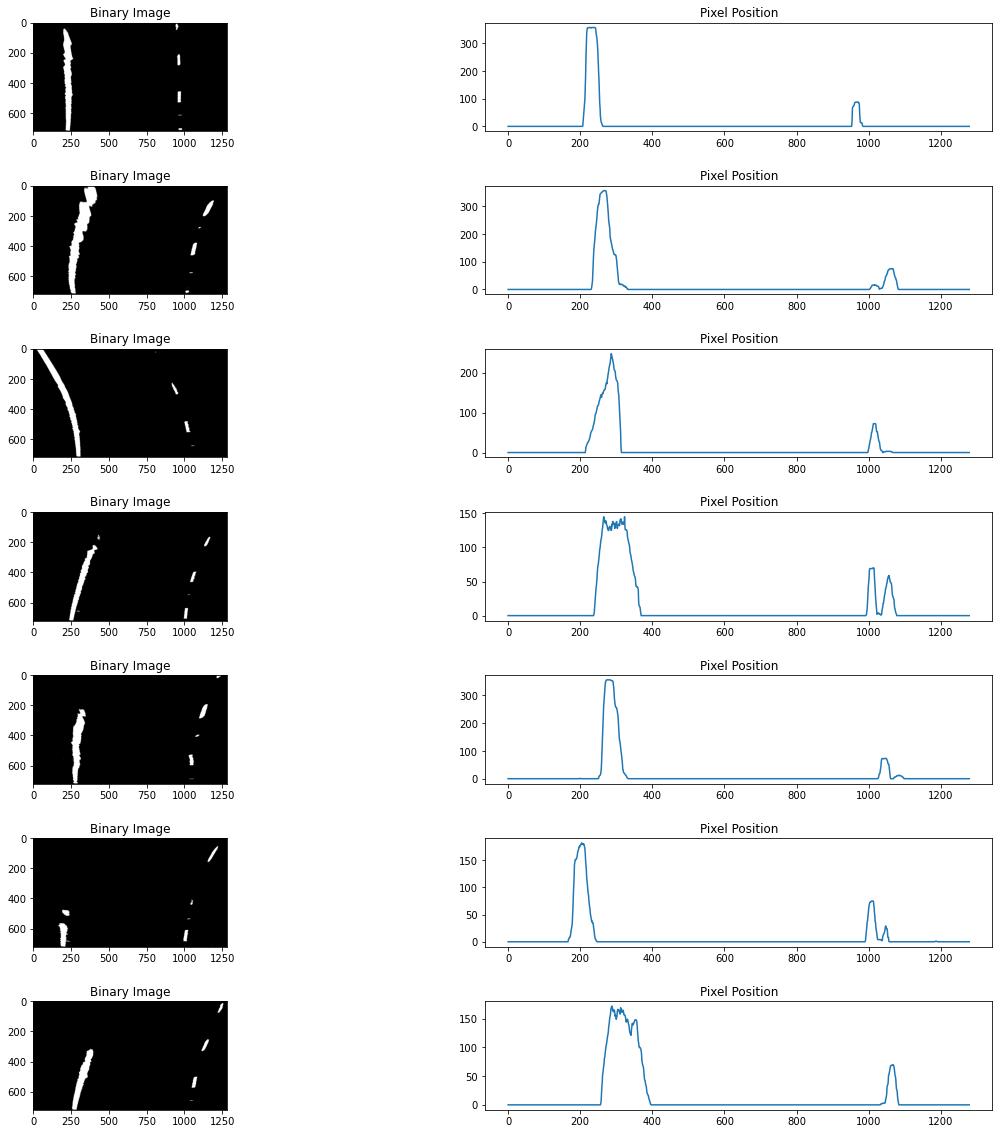

In [168]:
f,axes= plt.subplots(len(binary_images),2, figsize=(20,20))
f.subplots_adjust(hspace =0.5)
row=0
for image in binary_images:
    axes[row,0].imshow(image,cmap='gray')
    axes[row,0].set_title('Binary Image')
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    axes[row,1].plot(histogram)
    axes[row,1].set_title('Pixel Position')  
    row+=1 

## Ready code for testing

In [169]:

fit_prev_left=[]
fit_prev_right=[]
fit_sum_left=0
fit_sum_right=0
def Plot_line(binary_warped, smoothen=False,prevFrameCount=6 ): #used Udacity's code to plot the lines and windows over lanes 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_width= abs(rightx_base-leftx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(smoothen):
        global fit_prev_left
        global fit_prev_right
        global fit_sum_left
        global fit_sum_right
        if(len(fit_prev_left)>prevFrameCount):
            fit_sum_left-= fit_prev_left.pop(0)
            fit_sum_right-= fit_prev_right.pop(0)

        fit_prev_left.append(left_fit)
        fit_prev_right.append(right_fit)
        fit_sum_left+=left_fit
        fit_sum_right+= right_fit

        no_of_fit_values=len(fit_prev_left) 
        left_fit= fit_sum_left/no_of_fit_values
        right_fit= fit_sum_right/no_of_fit_values
    
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return out_img, result, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width

          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

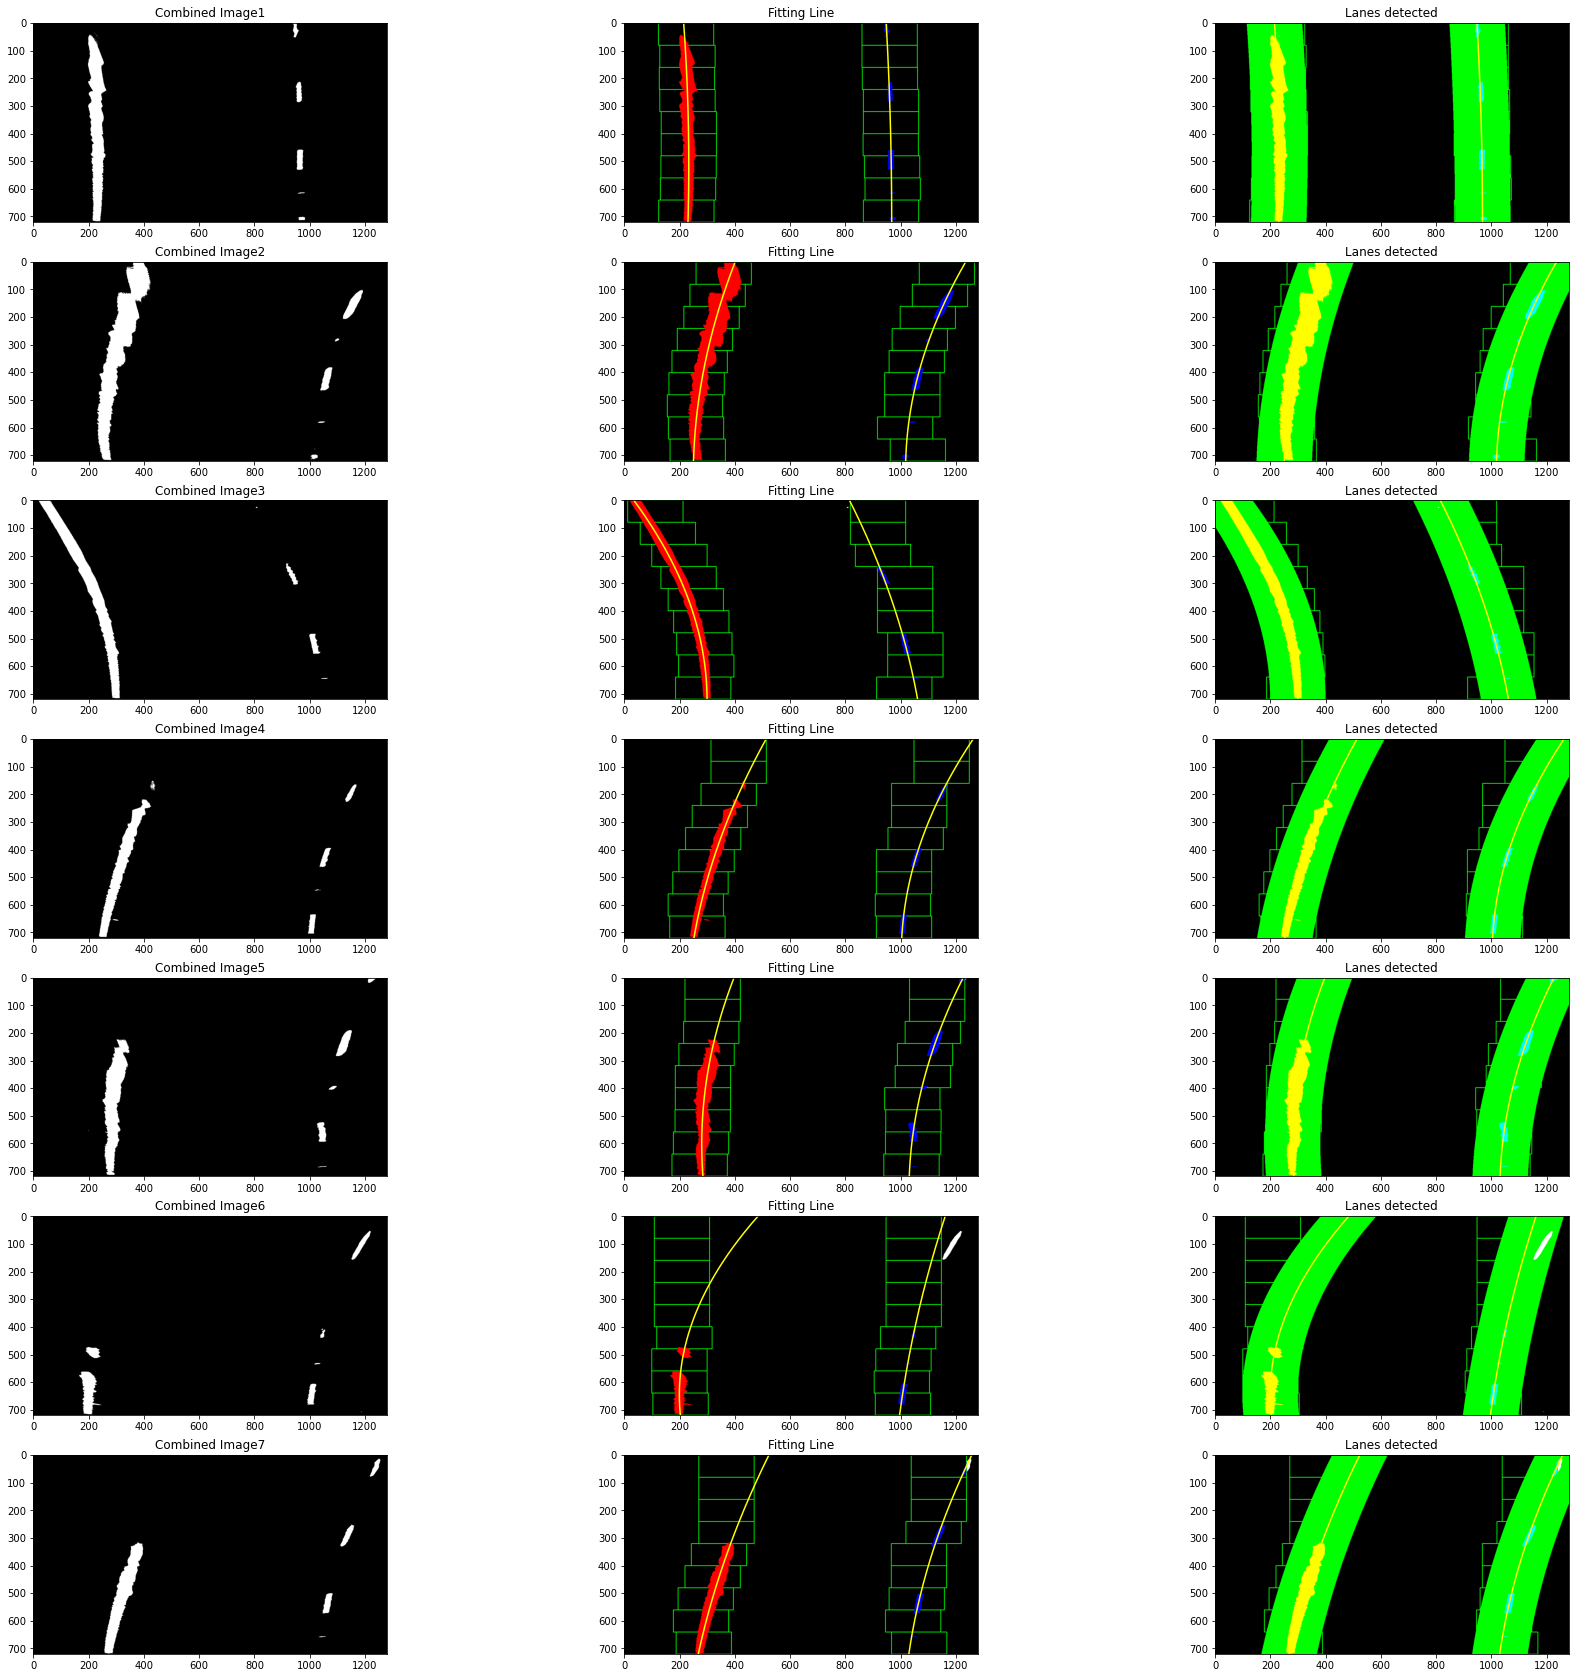

In [170]:
f,axes= plt.subplots(len(binary_images),3, figsize=(30,30))
f.subplots_adjust(hspace =0.2, wspace=0.2)
row=0

for image in binary_images:
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    axes[row,0].imshow(image,cmap='gray')
    axes[row,0].set_title('Combined Image'+str(row+1))
    

    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(image)
    axes[row,1].imshow(out_img)
    axes[row,1].plot(left_fitx, ploty, color='yellow')
    axes[row,1].plot(right_fitx, ploty, color='yellow')
    axes[row,1].set_title('Fitting Line')
    
    axes[row,2].imshow(out_img1)
    axes[row,2].plot(left_fitx, ploty, color='yellow')
    axes[row,2].plot(right_fitx, ploty, color='yellow')
    axes[row,2].set_title("Lanes detected")
    
    row+=1

In [171]:
def draw_lane(original_img, Combined_img, left_fitx, right_fitx, M):
    new_img = np.copy(original_img)

    warp_zero = np.zeros_like(Combined_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = Combined_img.shape
    ploty = np.linspace(0, h-1, num=h)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)

    return color_warp, new_img

In [172]:
center_distances= Queue(maxsize=15)
distanceSum=0
def get_car_position(l_fit, r_fit,w,h):
    xm_per_pix=3.7/700
    center_dist=0
    lane_center_position=0
    if r_fit is not None and l_fit is not None:
        car_position = w/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    global distanceSum           
    if(center_distances.full()):
        el=center_distances.get()
        distanceSum-=el
    
    center_distances.put(center_dist)
    distanceSum+=center_dist
    
    no_of_distance_values=center_distances.qsize() 
    center_dist= distanceSum/no_of_distance_values
    return center_dist,lane_center_position


In [173]:
def get_direction(center_dist):
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    return direction

In [174]:
def Plot_details(laneImage,curv_rad,center_dist,width_lane,lane_center_position):
    offest_top=0
    copy= np.zeros_like(laneImage)
    
    h = laneImage.shape[0]
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(laneImage, text, (40,70+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(copy, text, (40,100+offest_top), font, 4.0, (255,255,255), 3, cv2.LINE_AA)
    
    abs_center_dist = abs(center_dist)
    direction= get_direction(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
#     cv2.putText(laneImage, 'steering '+direction, (40,110+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(laneImage, '|', (640,710), font, 2.0, (255,255,255), 3, cv2.LINE_AA)
    cv2.putText(laneImage, '|', (int(lane_center_position),680), font, 2.0, (255,0,0), 3, cv2.LINE_AA)
    cv2.putText(laneImage, text, (40,120+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    
    text = 'Lane Width: ' + '{:04.2f}'.format(width_lane) + 'm'
    cv2.putText(laneImage, text, (40,170+offest_top), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(copy, text, (40,280+offest_top), font, 4.0, (255,255,255), 3, cv2.LINE_AA)
    
    return laneImage, copy

In [175]:
width_lane_avg=[]
radius_values = Queue(maxsize=15)
radius_sum=0

def calc_radius_position(combined, l_fit, r_fit, l_lane_inds, r_lane_inds,lane_width):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist, width_lane = (0, 0, 0, 0)
    h = combined.shape[0]
    w = combined.shape[1]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        #applying the formula for 
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        width_lane= lane_width*xm_per_pix
        if(len(width_lane_avg) != 0):
            avg_width=(sum(width_lane_avg)/len(width_lane_avg))
            if abs(avg_width-width_lane)<0.5:
                width_lane_avg.append(width_lane)
            else:
                width_lane=avg_width
    
    
    # Averaging radius value over past 15 frames
    global radius_sum           
    if(radius_values.full()):
        el=radius_values.get()
        
        radius_sum-=el
    curve_radius= (left_curverad+right_curverad)/2
    radius_values.put(curve_radius)
    radius_sum+=curve_radius
    
    no_of_radius_values=radius_values.qsize() 
    curve_radius= radius_sum/no_of_radius_values
#     print(curve_radius, radius_sum,no_of_radius_values)
    
    center_dist,lane_center_position= get_car_position(l_fit,r_fit,w,h) #getting the car distance from the center
    return curve_radius, center_dist,width_lane,lane_center_position

## Pipeline to handle stages in sequence 

In [176]:
def Lane_pipeline(img,smoothen,prevFrameCount):
    warped_image,M= perspective_Trans(img)
    image_HLS= cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)
    image_CRCB=cv2.cvtColor(warped_image,cv2.COLOR_RGB2YCrCb)
    h, l, s = cv2.split(image_HLS)
    Y, Cr, Cb = cv2.split(image_CRCB)
    bin_l=binary_Thresholding(l,(215,255))
    bin_Cr=binary_Thresholding(Cr,(215,255))
    bin_Cb=binary_Thresholding(Cb,(0,40))
    bin_y=binary_Thresholding(Y,(215,255))
    combined= cv2.bitwise_or(bin_l,bin_Cr)
    combined= cv2.bitwise_or(combined,bin_y)
    combined= cv2.bitwise_or(combined,bin_Cb)
    out_img,out_img1, left_fitx,right_fitx,ploty,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width= Plot_line(combined,smoothen,prevFrameCount)
    curverad,center_dist,width_lane,lane_center_position= calc_radius_position(combined,left_fit, right_fit,left_lane_inds,right_lane_inds,lane_width)
    laneImage,new_img =draw_lane(img, combined, left_fitx, right_fitx, M)
    unwarped_image= reverse_Perspective(laneImage,M)
    laneImage = cv2.addWeighted(new_img, 1, unwarped_image, 0.5, 0)
    laneImage, copy = Plot_details(laneImage,curverad,center_dist,width_lane,lane_center_position)
    return img,out_img,out_img1,unwarped_image,laneImage,combined,copy

# So the results after the above stages  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


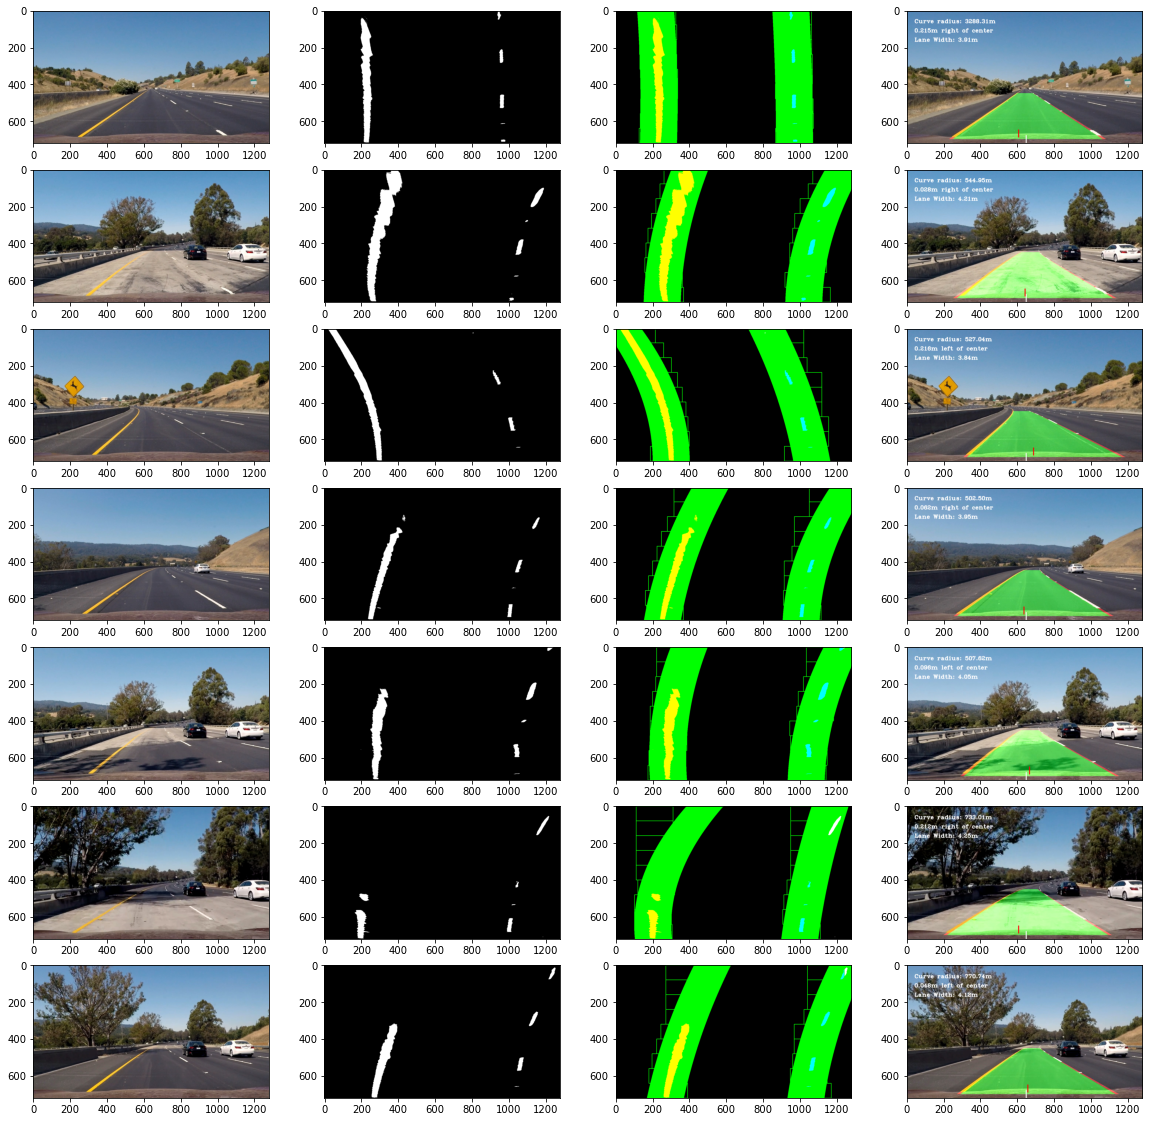

In [180]:
f,axes= plt.subplots(7,4, figsize=(20,20))
row=0

for index in range(7):
    global fit_prev_left
    global fit_prev_right
    global fit_sum_left
    global fit_sum_right
    global radius_sum
    global radius_values
    global center_distances
    global distanceSum
    fit_prev_left=[]
    fit_prev_right=[]
    fit_sum_left=0
    fit_sum_right=0
    radius_sum=0
    radius_values.queue.clear()
    center_distances.queue.clear()
    distanceSum=0
    
    image= test_images[index]
    image= ConvertBGRtoRGB(image)
    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,copy= Lane_pipeline(image, False,0)
    
    axes[row,0].imshow(rgb_image)
    axes[row,1].imshow(combined, cmap='gray')
    axes[row,2].imshow(out_img1)
    axes[row,3].imshow(laneImage)
    row+=1

In [181]:
def CallPipeline(image):
    smoothen= True
    prevFrameCount=0
    rgb_image,out_img,out_img1,unwarped_image,laneImage,combined,data_copy= Lane_pipeline(image,smoothen,prevFrameCount)

    out_image = np.zeros((720,1280,3), dtype=np.uint8)
    
    #stacking up various images in one output Image
    out_image[0:720,0:1280,:] = cv2.resize(laneImage,(1280,720)) #top-left
    out_image[20:190,960:1260,:] = cv2.resize(np.dstack((combined*255, combined*255, combined*255)),(300,170))#side Panel
    out_image[210:380,960:1260,:] = cv2.resize(out_img,(300,170))#side Panel
#     out_image[400:570,960:1260,:] = cv2.resize(data_copy,(300,170))#bottom-left
    return out_image

In [ ]:
video_output1 = 'project_video_output5.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(20,25)
processed_video = video_input1.fl_image(CallPipeline)
%time processed_video.write_videofile(video_output1, audio=False)